# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf



/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [2]:
# %load_ext nb_black

In [3]:
def remove_moa(df):
    pipes = ['cholesterol inhibitor|lipase clearing factor inhibitor'
         'serotonin receptor agonist|serotonin receptor antagonist',
             'acetylcholine receptor agonist|benzodiazepine receptor agonist',
             'adrenergic receptor agonist|serotonin receptor agonist',
            'cyclooxygenase inhibitor|lipoxygenase inhibitor'] 
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [4]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(7903, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [9]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [10]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=.3,
    verbose=True,
)
cp_vae.compile_vae()

2021-12-23 17:46:52.358026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 17:46:52.358072: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 17:46:52.358104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2021-12-23 17:46:52.358375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/keras/optimizer_v

In [11]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

2021-12-23 17:46:53.856275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
83/83 [==============================] - 3s 13ms/step - loss: 31.7633 - recon: 30.9337 - kl: 0.8296 - mmd: 0.0000e+00 - val_loss: 67.9548 - val_recon: 63.2569 - val_kl: 4.6979 - val_mmd: 0.0000e+00
Epoch 2/100
83/83 [==============================] - 1s 7ms/step - loss: 8.0775 - recon: 7.4514 - kl: 0.6261 - mmd: 0.0000e+00 - val_loss: 7.6231 - val_recon: 6.6782 - val_kl: 0.9449 - val_mmd: 0.0000e+00
Epoch 3/100
83/83 [==============================] - 1s 7ms/step - loss: 6.3487 - recon: 5.7557 - kl: 0.5930 - mmd: 0.0000e+00 - val_loss: 6.6776 - val_recon: 5.6552 - val_kl: 1.0224 - val_mmd: 0.0000e+00
Epoch 4/100
83/83 [==============================] - 1s 7ms/step - loss: 5.1983 - recon: 4.6200 - kl: 0.5782 - mmd: 0.0000e+00 - val_loss: 5.4182 - val_recon: 4.5628 - val_kl: 0.8555 - val_mmd: 0.0000e+00
Epoch 5/100
83/83 [==============================] - 1s 7ms/step - loss: 4.5371 - recon: 3.9557 - kl: 0.5814 - mmd: 0.0000e+00 - val_loss: 4.4113 - val_recon: 3.7208 - val_kl:

Epoch 41/100
83/83 [==============================] - 1s 7ms/step - loss: 2.8354 - recon: 2.0937 - kl: 0.7417 - mmd: 0.0000e+00 - val_loss: 2.8330 - val_recon: 1.9842 - val_kl: 0.8489 - val_mmd: 0.0000e+00
Epoch 42/100
83/83 [==============================] - 1s 7ms/step - loss: 2.8381 - recon: 2.0941 - kl: 0.7440 - mmd: 0.0000e+00 - val_loss: 2.6498 - val_recon: 1.9191 - val_kl: 0.7307 - val_mmd: 0.0000e+00
Epoch 43/100
83/83 [==============================] - 1s 7ms/step - loss: 2.8345 - recon: 2.0756 - kl: 0.7589 - mmd: 0.0000e+00 - val_loss: 2.7318 - val_recon: 1.8842 - val_kl: 0.8476 - val_mmd: 0.0000e+00
Epoch 44/100
83/83 [==============================] - 1s 7ms/step - loss: 2.7958 - recon: 2.0537 - kl: 0.7421 - mmd: 0.0000e+00 - val_loss: 2.6984 - val_recon: 1.9196 - val_kl: 0.7789 - val_mmd: 0.0000e+00
Epoch 45/100
83/83 [==============================] - 1s 7ms/step - loss: 2.8000 - recon: 2.0517 - kl: 0.7483 - mmd: 0.0000e+00 - val_loss: 2.6705 - val_recon: 1.9102 - val_kl:

Epoch 81/100
83/83 [==============================] - 1s 7ms/step - loss: 2.5294 - recon: 1.7322 - kl: 0.7973 - mmd: 0.0000e+00 - val_loss: 2.4412 - val_recon: 1.5754 - val_kl: 0.8658 - val_mmd: 0.0000e+00
Epoch 82/100
83/83 [==============================] - 1s 7ms/step - loss: 2.5399 - recon: 1.7416 - kl: 0.7983 - mmd: 0.0000e+00 - val_loss: 2.7662 - val_recon: 1.9477 - val_kl: 0.8185 - val_mmd: 0.0000e+00
Epoch 83/100
83/83 [==============================] - 1s 7ms/step - loss: 2.5087 - recon: 1.7071 - kl: 0.8016 - mmd: 0.0000e+00 - val_loss: 2.4848 - val_recon: 1.6059 - val_kl: 0.8790 - val_mmd: 0.0000e+00
Epoch 84/100
83/83 [==============================] - 1s 7ms/step - loss: 2.5226 - recon: 1.7266 - kl: 0.7960 - mmd: 0.0000e+00 - val_loss: 2.4193 - val_recon: 1.6662 - val_kl: 0.7531 - val_mmd: 0.0000e+00
Epoch 85/100
83/83 [==============================] - 1s 7ms/step - loss: 2.4948 - recon: 1.6981 - kl: 0.7967 - mmd: 0.0000e+00 - val_loss: 2.4786 - val_recon: 1.6239 - val_kl:

In [12]:
cp_vae.vae

In [13]:
# cp_vae.vae.evaluate(test_features_df)

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,31.763348,30.933744,0.829605,0.0,67.954811,63.256916,4.697882,0.0
1,8.077526,7.451380,0.626148,0.0,7.623065,6.678206,0.944858,0.0
2,6.348714,5.755732,0.592982,0.0,6.677600,5.655166,1.022433,0.0
3,5.198285,4.620042,0.578243,0.0,5.418239,4.562758,0.855481,0.0
4,4.537093,3.955676,0.581416,0.0,4.411256,3.720848,0.690407,0.0
...,...,...,...,...,...,...,...,...
95,2.476143,1.673607,0.802535,0.0,2.398746,1.517162,0.881584,0.0
96,2.457397,1.654558,0.802839,0.0,2.418729,1.539819,0.878910,0.0
97,2.434899,1.631461,0.803438,0.0,2.411274,1.513065,0.898209,0.0
98,2.449145,1.643982,0.805164,0.0,2.651842,1.845506,0.806337,0.0


In [15]:
history_df.to_csv('training_data/level5_training_leaveIntermediateOut.csv')

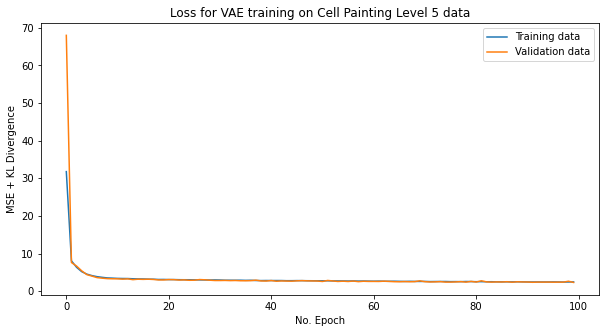

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [17]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

38.82193953621928

<AxesSubplot:>

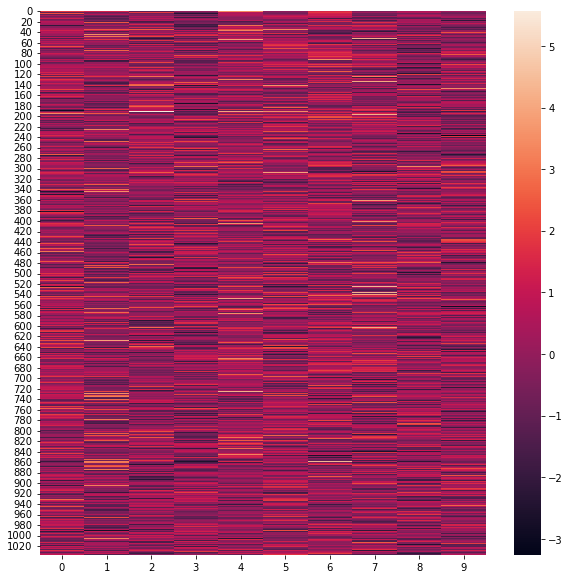

In [18]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [19]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

In [20]:
decoder = cp_vae.decoder_block["decoder"]

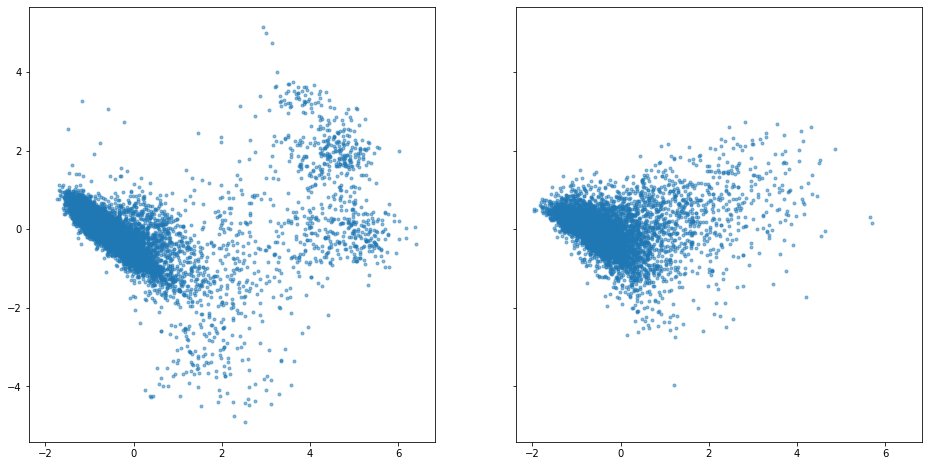

In [21]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [22]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

5.257343134564753

In [23]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_leaveIntermediateOut.csv")

In [24]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level5Decoder_leaveIntermediateOut")

2021-12-23 17:47:58.026067: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/level5Decoder_leaveIntermediateOut/assets


In [25]:
encoder.save("models/level5Encoder_leaveIntermediateOut")

INFO:tensorflow:Assets written to: models/level5Encoder_leaveIntermediateOut/assets
